In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import healpy as hp
from rubin_sim.scheduler.model_observatory import KinemModel
from rubin_sim.utils import angular_separation
from rubin_sim.scheduler.utils import generate_all_sky

In [22]:
conn = sqlite3.connect('baseline_v3.3_10yrs.db')
query = "select observationStartMJD, filter, altitude, azimuth, rotTelPos, rotSkyPos, fieldRA, fieldDec, slewtime,"\
        "slewDistance, visitTime, night, note from observations where night=82"
dd = pd.read_sql(query, conn)

In [23]:
n82 = dd.query('night == 82')
len(n82), n82['note'].unique()
# pair_15 = 15 minute separated pairs of visits, taken during twilight
# pair_33 = standard 'blobs' separated by 33 minutes between visits

(1011,
 array(['pair_15, iz, a', 'pair_15, iz, b', 'pair_33, ug, a',
        'pair_33, ug, b', 'pair_33, ur, a', 'pair_33, ur, b',
        'pair_33, ri, a', 'pair_33, ri, b', 'pair_33, iz, a',
        'pair_33, iz, b', 'pair_15, ri, a', 'pair_15, ri, b'], dtype=object))

In [24]:
dtime = np.diff(n82['observationStartMJD'])
dtime = dtime * 24 * 60 * 60

Text(0, 0.5, 'slew distance')

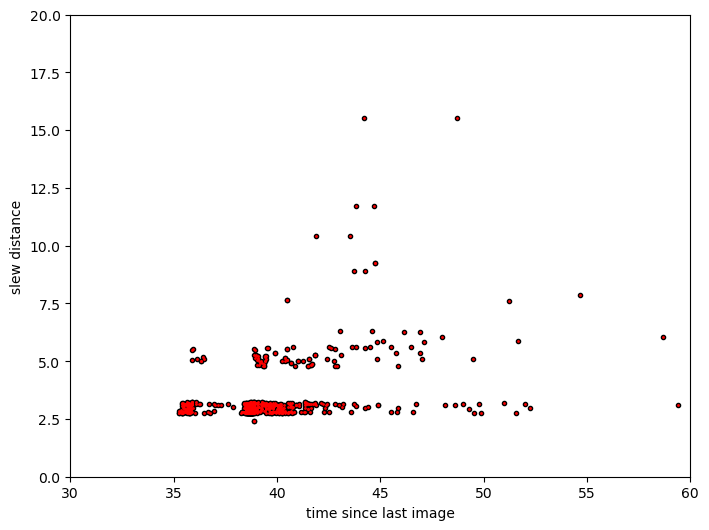

In [25]:
# Can I recreate Aaron's plot? - yes, looks like
plt.figure(figsize=(8, 6))
plt.plot(dtime, n82['slewDistance'].values[1:], 'k.')
plt.plot(n82['slewTime']+n82['visitTime'], n82['slewDistance'], 'r.', markersize=2)
plt.xlim(30, 60)
plt.ylim(0, 20)
plt.xlabel('time since last image')
plt.ylabel('slew distance')

Text(0, 0.5, 'slew distance')

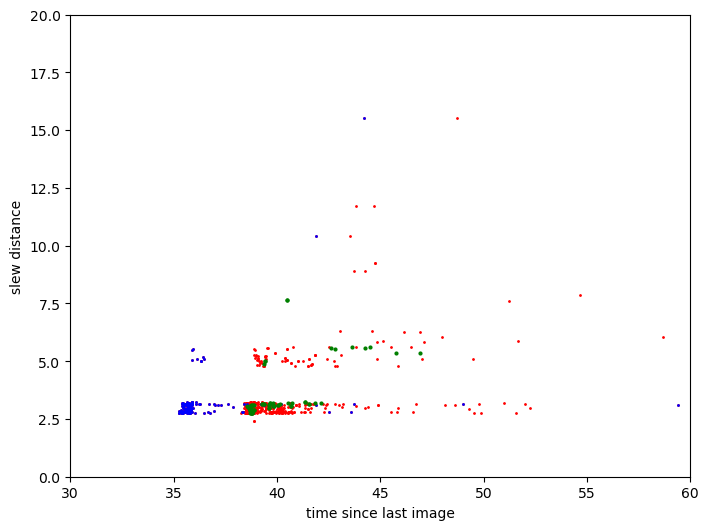

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(n82['slewTime']+n82['visitTime'], n82['slewDistance'], 'r.', markersize=2)
# Mark the u-band visits 
subset = n82.query('filter == "u"')
plt.plot(subset['slewTime']+subset['visitTime'], subset['slewDistance'], 'b.', markersize=2)
# Mark the twilight visits
subset = n82.query('note.str.contains("pair_15")')
plt.plot(subset['slewTime']+subset['visitTime'], subset['slewDistance'], 'go', markersize=2)
plt.xlim(30, 60)
plt.ylim(0, 20)
plt.xlabel('time since last image')
plt.ylabel('slew distance')

Text(0, 0.5, 'slew distance')

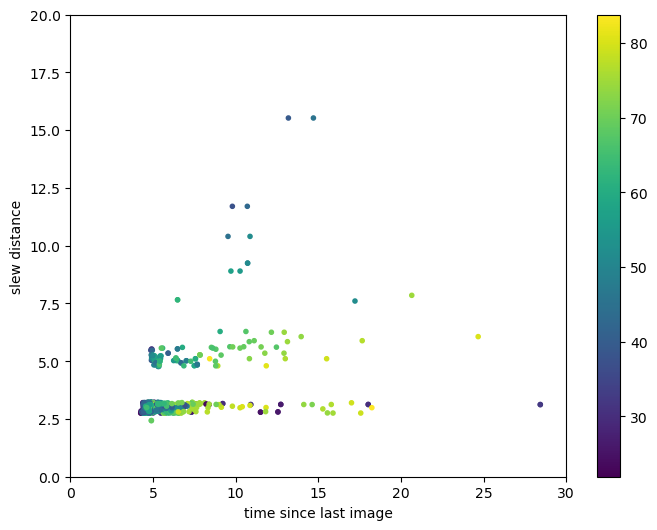

In [27]:
plt.figure(figsize=(8, 6))
# Let's remove the u-band visit difference and also color-code by altitude
plt.scatter(n82['slewTime'], n82['slewDistance'], c=n82['altitude'], marker='.')
plt.colorbar()
plt.xlim(0, 30)
plt.ylim(0, 20)
plt.xlabel('time since last image')
plt.ylabel('slew distance')

(0.0, 30.0)

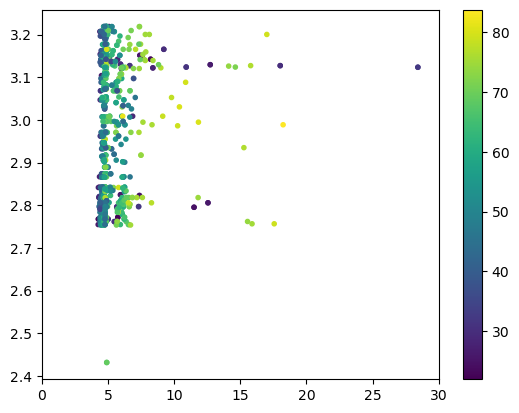

In [28]:
# Let's focus specifically on the range of slew times for distances < 4 deg
subset = n82.query('slewDistance < 4')
plt.scatter(subset['slewTime'], subset['slewDistance'], c=subset['altitude'], marker='.')
plt.colorbar()
plt.xlim(0, 30)

In [29]:
# High altitude visits may have longer slew times because the separation 
subset = n82.query('slewDistance<4 and slewTime>25 and slewTime<30')
subset

,observationStartMJD,filter,altitude,azimuth,rotTelPos,rotSkyPos,fieldRA,fieldDec,slewTime,slewDistance,visitTime,night,note
57,60877.989704,u,31.818182,177.736607,53.354197,104.884645,275.77902,-87.50246,28.428919,3.123352,31.0,82,"pair_33, ug, a"
107,60878.013768,g,32.095253,178.039949,62.192989,104.884645,275.77902,-87.50246,28.428919,3.123352,34.0,82,"pair_33, ug, b"


In [31]:
pd.concat([n82.loc[56:58], n82.loc[106:108]])

,observationStartMJD,filter,altitude,azimuth,rotTelPos,rotSkyPos,fieldRA,fieldDec,slewTime,slewDistance,visitTime,night,note
56,60877.989017,u,28.757574,178.504757,52.964902,192.135861,3.549538,-88.024137,40.946562,5.054266,31.0,82,"pair_33, ug, a"
57,60877.989704,u,31.818182,177.736607,53.354197,104.884645,275.779020,-87.502460,28.428919,3.123352,31.0,82,"pair_33, ug, a"
58,60877.990272,u,29.459974,175.368450,53.515539,155.712272,325.554199,-85.907453,18.022179,3.127118,31.0,82,"pair_33, ug, a"
106,60878.013045,g,28.969231,178.263964,61.517452,192.135861,3.549538,-88.024137,40.946562,5.054266,34.0,82,"pair_33, ug, b"
107,60878.013768,g,32.095253,178.039949,62.192989,104.884645,275.779020,-87.502460,28.428919,3.123352,34.0,82,"pair_33, ug, b"
108,60878.014370,g,30.074347,175.270459,62.143783,155.712272,325.554199,-85.907453,18.022179,3.127118,34.0,82,"pair_33, ug, b"


In [49]:
kinematic = KinemModel()
# Set up a grid of ra/dec points over the sky 
sky = generate_all_sky(nside=128)

In [68]:
# Calculate slewtimes over the entire sky from the end of the visit just before one in question
idx = 56
kinematic.current_filter = 'u'
slewtimes = kinematic.slew_times(np.radians(sky['ra']), np.radians(sky['dec']), 
                                 n82.loc[idx, 'observationStartMJD'] + 31/60/60/24.0, 
                                rot_sky_pos=None,
                                rot_tel_pos=None,
                                filtername="u",
                                lax_dome=True,
                                starting_alt_rad=np.radians(n82.loc[idx, 'altitude']),
                                starting_az_rad=np.radians(n82.loc[idx, "azimuth"]),
                                starting_rot_tel_pos_rad=np.radians(n82.loc[idx, "rotTelPos"]),
                                update_tracking=False)

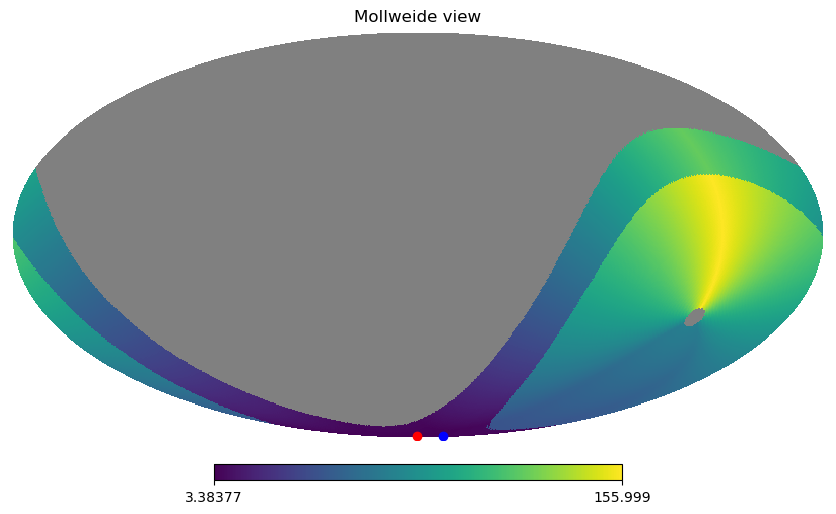

In [69]:
hp.mollview(slewtimes)
hp.projscatter(n82.loc[idx, 'fieldRA'], n82.loc[idx, 'fieldDec'], lonlat=True, color='r')
hp.projscatter(n82.loc[idx+1, 'fieldRA'], n82.loc[idx+1, 'fieldDec'], lonlat=True, color='b')

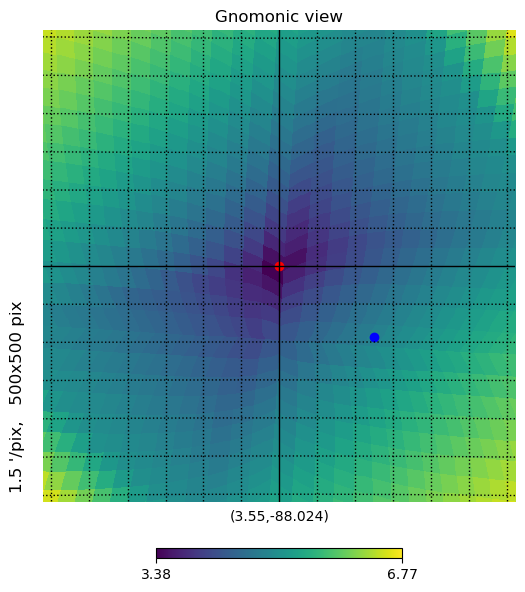

In [70]:
hp.gnomview(slewtimes, rot=(n82.loc[idx, 'fieldRA'], n82.loc[idx, 'fieldDec'], 0), xsize=500)
hp.projscatter(n82.loc[idx, 'fieldRA'], n82.loc[idx, 'fieldDec'], lonlat=True, color='r')
hp.projscatter(n82.loc[idx+1, 'fieldRA'], n82.loc[idx+1, 'fieldDec'], lonlat=True, color='b')
hp.graticule()

This suggests the slewtime to that point should have been <5 seconds instead of >20, so what's going on? 

In [72]:
# could it be the rotator? 
# or maybe cable wrap, but I don't see where/how the ModelObservatory is tackling cable wrap

slewtimes = kinematic.slew_times(np.radians(n82.loc[idx+1, 'fieldRA']), np.radians(n82.loc[idx+1, 'fieldDec']),
                                 mjd=n82.loc[idx, 'observationStartMJD'] + 31/60/60/24.0, 
                                rot_sky_pos=np.radians(n82.loc[idx+1, 'rotSkyPos']),
                                rot_tel_pos=np.radians(n82.loc[idx+1, 'rotTelPos']),
                                filtername="u",
                                lax_dome=True,
                                starting_alt_rad=np.radians(n82.loc[idx, 'altitude']),
                                starting_az_rad=np.radians(n82.loc[idx, "azimuth"]),
                                starting_rot_tel_pos_rad=np.radians(n82.loc[idx, "rotTelPos"]),
                                update_tracking=False)

IndexError: invalid index to scalar variable.